Final assignment for the course: Betriebssystem und Programmierung - Lehrveranstaltung 3 (Python) under the supervision of [Prof. Dr. Kristian Rother](https://github.com/krother).

Students:
- Marcelo Avila - Economics
- Marek Felten - Geography


This project aims to explore some of python capabilites at dealing with geospatial information, while also documenting the work related to the collection, cleaning, analysing and displaying the results. The results should be clear and reproducible by the reader.

The main libraries used in this project are: 
- jupyter
- pandas
- basemap
- folium


## The data

The [data](http://www.start.umd.edu/gtd/about/) is from an "open-source database including information on terrorist events around the world from 1970 through 2016". The data is maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) 

### Disclaimer:

As clearly pointed out in [this article by the Wahshington Post](https://www.washingtonpost.com/news/monkey-cage/wp/2014/08/11/how-to-fix-the-flaws-in-the-global-terrorism-database-and-why-it-matters/), the data suffers from breaks in its methodology. However they are aggregated withouth consideration for its effects on temporal trends, as one can see in the following graphic. So any comparison accross years that crosses suche breaks might be misleading. 

> ![Washington Post](https://img.washingtonpost.com/blogs/monkey-cage/files/2014/08/cpost.png "")
> source: "How to fix the flaws in the Global Terrorism Database and why it matters", by 
> Robert Pape, Keven Ruby, Vincent Bauer and Gentry Jenkins, from August 11, 2014

## before we start: 
The following code is under the [MIT-License](https://tldrlegal.com/license/mit-license).

# Lets start

In this first section we will import the modules, download the data and save a subset of the data, with which we will work later on.
## importing modules

In [2]:
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import os
import pandas as pd
import requests
from ipywidgets import widgets

# to circumvent some of the extensive warnings from BASEMAP.
import warnings
warnings.filterwarnings('ignore')

### Downloading the data 
request the data and save a local copy named as "GTD_full.xlsx".

The data are available at the [University of Maryland](http://www.start.umd.edu/gtd/contact/) website.

The [data of Year 1993 was lost](http://www.start.umd.edu/gtd/faq/#q9) and they provide some recovered data in a separate file. Therefore, we also need to download and merge it with the main file.

In [13]:
# first create some folders for the following data if not already there
if os.path.exists("./data/"):
    print("folder: './data/' already there.")
else:
    os.mkdir("./data/")
    print("created folder '/data/'")
    
if os.path.exists("./output/"):
    print("folder: './output/' already there.")
else:
    os.mkdir("./output/")
    print("created folder './output/'")

folder: './data/' already there.
folder: './output/' already there.


In [2]:
# download full database, if not already there
if os.path.exists("data/GTD_full.xlsx"):
    print("GTD_full.xlsx already there. No need to download again.")
else:
    print("GTD_full.xlsx not found, so lets download it") # might take a minute or two
    url = "http://apps.start.umd.edu/gtd/downloads/dataset/globalterrorismdb_0617dist.xlsx"
    resp = requests.get(url)
    with open("data/GTD_full.xlsx", "wb") as f:
        f.write(resp.content)

# download 1993 database, if not already there        
if os.path.exists("data/GTD_1993.xlsx"):
    print("GTD_1993.xlsx already there. No need to download again.")
else:
    print("GTD_1993.xlsx not found, so lets download it") # might take a minute or two
    url93 = "http://apps.start.umd.edu/gtd/downloads/dataset/gtd1993_0617dist.xlsx"
    resp = requests.get(url93)
    with open("data/GTD_1993.xlsx", "wb") as f:
        f.write(resp.content)

GTD_full.xlsx already there. No need to download again.
GTD_1993.xlsx already there. No need to download again.


(it turns out you can download the data directly into pandas with 

```python
url93 = "http://apps.start.umd.edu/gtd/downloads/dataset/gtd1993_0617dist.xlsx"
df_93 = pd.read_excel(url93)
```
but since we also would like to have keep a local copy of the file, we will leave how it is)

Next, we save the data for year 1993 as data frame and drop one column ("individual") which consists of only zeros (0) and this collumn is not present in the full database. Then we append the 1993 data into the full data frame, while we do that we also make sure the collumns ordering are kept as before and we fit (sort) the 1993 in its right place. 


In [3]:
df_full = pd.read_excel("data/GTD_full.xlsx") # can take up to few minutes.
df_93 = pd.read_excel("data/GTD_1993.xlsx")
df_93.drop("individual", axis=1, inplace=True)

df_full = df_full.append(df_93, ignore_index=True)[df_full.columns.tolist()]
df_full = df_full.sort_values("eventid", ascending=True)

Now we make a list of variables to keep and drop the rest of the data frame and call the data frame we will be working with "df". 

In [4]:
keep = ["eventid", "iyear", "country_txt", "region_txt", "city", 
        "latitude", "longitude", "attacktype1_txt", "weaptype1_txt",
        "targtype1_txt", "gname", "nkill", "nkillter", "nwound",]
df = df_full[keep]
df = df.set_index(["eventid"])

In [5]:
del df_full # delete the data.frame since we wont need them anymore
del df_93

Lets create a new atribute, *ttkill* for the total number of fatalities, including the victims and the perpetrators and then save the smaller file as a csv. 

In [6]:
df["ttkill"] = df["nkill"].fillna(0) + df["nkillter"].fillna(0) 

In [7]:
df.to_csv("data/df_small.csv", encoding="utf-8")

## Missing data

In [14]:
# read the data from the file, if analysis is restarted. Otherwise carry on.
if 'df' in locals():
    print("df exists in locals, no need to read from csv.")
else:
    print("df does not exist in locals. Reading from csv.")
    df = pd.read_csv("data/df_small.csv")
    df.set_index(["eventid"], inplace=True)

df does not exist in locals. Reading from csv.


In [19]:
print("frequency of missing values \n\n",len(df) - df.count(),"\n\nobservations: ", len(df))

frequency of missing values 

 iyear                  0
country_txt            0
region_txt             0
city                 446
latitude            5353
longitude           5353
attacktype1_txt        0
weaptype1_txt          0
targtype1_txt          0
gname                  0
nkill               9698
nkillter           66714
nwound             15367
ttkill                 0
dtype: int64 

observations:  171097


It turns out there is not much missing data for the most interesting variables (although there are plenty of "unknown" events, which isn't technically missing values but its not *real* information also.)
The exception are:
- nkillter (number of perpretators killed)
- propextent (extension of damage to affected property)
- propvalue (value of damage to property)
                                                                                
Problematic, however, is the **latitude** and **longitude** values. This information if missing for all of the year **1993**.

We can get some approximate values by geocoding the country or city name into their respective longitude and latitude. This is approximation is precise enough when we intend to plot the data onto a world map. It can be misleading though for the dynamic plotting with folium, where the reader might zoom into a higher level accuracy. 

So we will now make a copy of the data frame and fill the latitude and longitude missing values with the median of the values of the attacks that occurred in the same city. 
Here we also have to be carefull with the filled values for the "Unknown" fields under "city". In order to fill the missing values only for those cities not called "Unknown", we first had to fill the missing values of the "Unknown" cities with a unique number (-999), then fill the rest of latitude and longitude missing values with the median conditinionally on the city that the attack occurred. Finally, we replaced the -999 values with 'np.NaN' again. 
This is surely not the most elegant way of achieving this result, but more intuitive methods, like conditionally filling up the NaN only for values where city is not equal to "Unknown" did not work. 

In [20]:
# we will use df93 where the exact locations is not an issue (i.e., plotting in the world map)
# and we will use df where it is (i.e., plotting with folium)
df93 = df.copy(deep=True) 

In [21]:
df93.loc[df93.iyear == 1993, ["city", "latitude", "longitude"]].head(3)

city  latitude  longitude
eventid                                    
199301010001   Belfast       NaN        NaN
199301010002     Luxor       NaN        NaN
199301030001  Vavuniya       NaN        NaN

In [22]:
df93.loc[df93.city == "Unknown", "latitude"] = df93.fillna(-999.0)
df93.loc[df93.city == "Unknown", "longitude"] = df93.fillna(-999.0)

df93["latitude"].fillna(df93.groupby(["country_txt", "city"])["latitude"].transform("median"), inplace=True)
df93["longitude"].fillna(df93.groupby(["country_txt", "city"])["longitude"].transform("median"), inplace=True)

df93.latitude.replace(-999.0, np.NaN, inplace = True)
df93.longitude.replace(-999.0, np.NaN, inplace = True)
df93.loc[df.iyear == 1993, ["city", "latitude", "longitude"]].head(3)

city   latitude  longitude
eventid                                     
199301010001   Belfast  54.597269  -5.930109
199301010002     Luxor  25.699433  32.644441
199301030001  Vavuniya   8.738157  80.477147

For the missing values of *nkill* and *nkillter* we have three opttions: 
1. do nothing about it
2. drop the missing data, (including the rest of the row)
3. fill it up with mean or median (so that other information are not lost)

In [23]:
print("mean nkill: {}".format(np.mean(df["nkill"].dropna())))
print("mean nkillter: {}".format(np.mean(df["nkillter"].dropna())))
print("median nkillter: {}".format(np.median(df["nkillter"].dropna())))
print("median nkill: {}".format(np.median(df["nkill"].dropna())))

mean nkill: 2.392968977502959
mean nkillter: 0.4816684709195942
median nkillter: 0.0
median nkill: 0.0


While the mean value is around 2.4, the median value of 0 suggests that most of the occurrences resulted in zero fatalities.  Assuming that is likely that if the information is missing, the attack might have been poorly reported and therefore it is plausible to assume that there were no victims for, at least, most of the missing values.  with that in mind, we fill the missing values for "nkill" and "nkillter" with 0, i.e., their respective median.

In [24]:
df['nkill'].fillna(0, inplace=True) 
df['nkillter'].fillna(0, inplace=True)

In [25]:
df.head(5) # that is what we have so far... 

iyear         country_txt                   region_txt  \
eventid                                                                
197000000001   1970  Dominican Republic  Central America & Caribbean   
197000000002   1970              Mexico                North America   
197001000001   1970         Philippines               Southeast Asia   
197001000002   1970              Greece               Western Europe   
197001000003   1970               Japan                    East Asia   

                       city   latitude   longitude  \
eventid                                              
197000000001  Santo Domingo  18.456792  -69.951164   
197000000002    Mexico city  19.432608  -99.133207   
197001000001        Unknown  15.478598  120.599741   
197001000002         Athens  37.983773   23.728157   
197001000003        Fukouka  33.580412  130.396361   

                             attacktype1_txt              weaptype1_txt  \
eventid                                                                   
197000000001                   Assassination                    Unknown   
197000000002     Hostage Taking (Kidnapping)                    Unknown   
197001000001                   Assassination                    Unknown   
197001000002               Bombing/Explosion  Explosives/Bombs/Dynamite   
197001000003  Facility/Infrastructure Attack                 Incendiary   

                            targtype1_txt                               gname  \
eventid                                                                         
197000000001  Private Citizens & Property                              MANO-D   
197000000002      Government (Diplomatic)  23rd of September Communist League   
197001000001          Journalists & Media                             Unknown   
197001000002      Government (Diplomatic)                             Unknown   
197001000003      Government (Diplomatic)                             Unknown   

              nkill  nkillter  nwound  ttkill  
eventid                                        
197000000001    1.0       0.0     0.0     1.0  
197000000002    0.0       0.0     0.0     0.0  
197001000001    1.0       0.0     0.0     1.0  
197001000002    0.0       0.0     NaN     0.0  
197001000003    0.0       0.0     NaN     0.0

## Exploratory Data Analysis

Here we will go through some of aspects of the data. The ideia is to have a little overview of the data and also use some of the pandas capabilities, such as pivot table, groupby, etc, and not really to explore the plotting capabilities of matplotlib. Therefore we will just go through the the methods without going into the aesthetics aspects of the plotting such as title, legents etc. 

### Groupby method

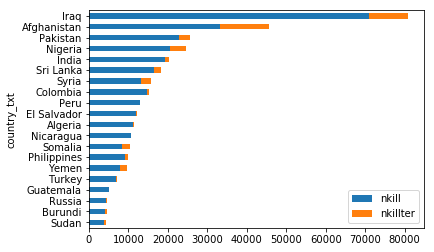

In [16]:
# get ust some columns of interest.
colsmall = ["country_txt", "nkill", "nkillter", "ttkill", "gname"]
# parameters by which to group by
grpby = ["country_txt"]

dfplot1 = df[colsmall].groupby(grpby).sum().sort_values("ttkill").tail(20)
dfplot1[["nkill", "nkillter"]].plot.barh(stacked=True)

### Pivot tables method

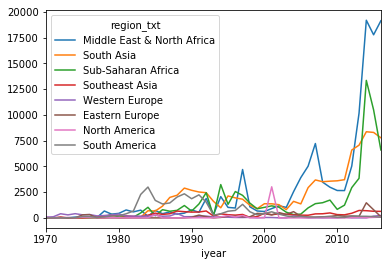

In [17]:
values = "nkill"
index = ["region_txt"]
columns = ["iyear"]

df_pv_region = pd.pivot_table(df, values = values, index = index, columns = columns, aggfunc=np.sum)
df_region_plot = df_pv_region.sort_values(2016, ascending = False).fillna(method ="ffill")

df_region_plot.dropna().head(8).T.plot()

### Aggregated by decade

the following code will create a new column "decade" and assign the relative decade to it, so that we can group by decade later on.

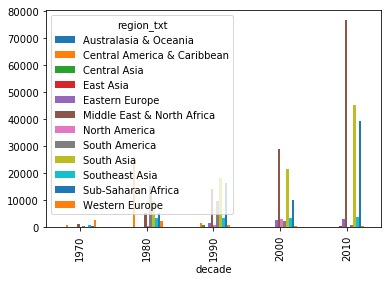

In [18]:
df["decade"] = ((df.iyear // 10) * 10)

values = "nkill"
index = ["region_txt"]#, "country_txt"]
columns = ["decade"]

tab1 = pd.pivot_table(df, values = values, index = index, columns = columns, aggfunc=np.sum)
tab1.T.plot.bar()

# Maps

Here we create some folders to store the output files we will create later on. The If conditions make sure we don't try to recreate the same folders again.

In [19]:
if os.path.exists("output/yearly"):
    print("folder 'output/yearly' already there!")
else:
    os.mkdir("output/yearly")
    print("created folder 'output/yearly'")

if os.path.exists("output/yearly_grow"):
    print("folder 'output/yearly_grow' already there!")
else:
    os.mkdir("output/yearly_grow")
    print("created folder 'output/yearly_grow'")
    
if os.path.exists("output/folium"):
    print("folder 'output/folium' already there!")
else:
    os.mkdir("output/folium")
    print("created folder 'output/folium'")

folder 'output/yearly' already there!
folder 'output/yearly_grow' already there!
folder 'output/folium' already there!


The following code will create three dictionaries, one for longitude, one latitude and one for the size (number of casualties) for each of the deadly attacks and for the non-dealdy ones (in which case, size is defined as the number of wounded). The dictionaries are then filled up with pandas series for the latitude and longitude values of each year.

Note: The name is a little misleading, suggesting it would only contain the 1993 information. In reality, it contains all information, including for 1993. 

In [26]:
# deadly attacks
lats93 = {}
lons93 = {}
size93 = {}

# non-deadly
lats0k = {}
lons0k = {}
size0k = {}

for year in range(1970, 2017):
    lats93["lat{}".format(year)] = df93[df93["iyear"].isin([year])].latitude
    lons93["lon{}".format(year)] = df93[df93["iyear"].isin([year])].longitude
    size93["siz{}".format(year)] = df93[df93["iyear"].isin([year])].ttkill
    
    lats0k["lat0k{}".format(year)] = df93.loc[(df.iyear == year) & (df.ttkill == 0), "latitude"]
    lons0k["lon0k{}".format(year)] = df93.loc[(df.iyear == year) & (df.ttkill == 0), "longitude"]
    size0k["siz0k{}".format(year)] = df93.loc[(df.iyear == year) & (df.ttkill == 0), "nwound"]    

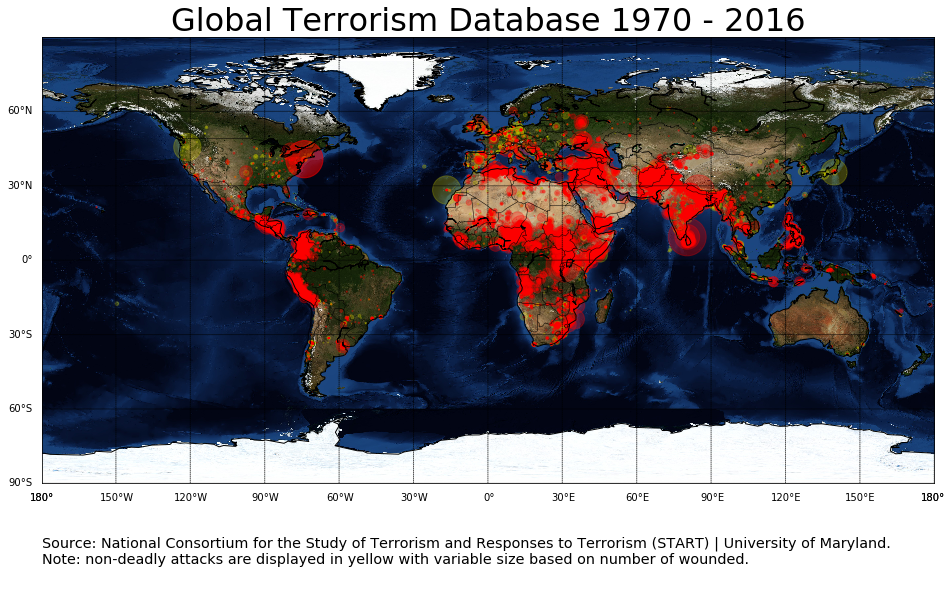

In [21]:
caption = '''Source: National Consortium for the Study of Terrorism \
and Responses to Terrorism (START) | University of Maryland. 
Note: non-deadly attacks are displayed in yellow with variable size \
based on number of wounded. 
'''

lat0 = df93["latitude"][df93["nkill"] == 0]
lon0 = df93["longitude"][df93["nkill"] == 0]
siz0 = df93["nwound"][df93["nkill"] == 0] # get number of wounded

lat1 = df93["latitude"][df93["nkill"] > 0]
lon1 = df93["longitude"][df93["nkill"] > 0]
siz1 = df93["ttkill"][df93["nkill"] > 0]

m = Basemap()

# compute geocoordinates based on lat and lon values for plotting on 2d map.
x0,y0 = m(lon0,lat0)
x1,y1 = m(lon1,lat1)

# create matplotlib figure
fig = plt.figure(figsize=(16,9))

# draw the "blue marble" map 
m.bluemarble()
# draw coastlines "borders"
m.drawcoastlines()
# draw countries borders
m.drawcountries()

# draw merdidians and parallels 
m.drawmeridians(np.arange(0, 360, 30), labels=[1,0,0,1])
m.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,1])

# plot points "(x0, y0)" and "(x1,y1) computed above
m.scatter(x0, y0, s = siz0, c = 'y', alpha = 0.3)  # draw non-deadly attacks in yellow
m.scatter(x1, y1, s = siz1, c = 'r', alpha = 0.3)  # draw deadly attacks in read

#add caption text and title
plt.figtext(0.125, 0.01, caption, size = "x-large")
plt.title("Global Terrorism Database 1970 - 2016", fontsize=32)

# save to output folder, display and close plot
plt.savefig("output/map_all.png", )
plt.show()
plt.close()

The widget works only in the jupyter notebook itself because the code needs to run everytime the user interacts with the slider. Therefore it wont come up in the html output.

The slider can be controlled with the mouse or by clicking on it and then wigh the left and right arrows.
(note: only when running the Notebook itself since there cannot be an interaction with the underlaying that at the HTML output)

In [27]:
def plt_year(year=1970):
    '''plot a map with lats and lons for each year'''
    fig = plt.figure(figsize=(10,10))
    m = Basemap()
    m.drawcoastlines()

    lon1 = lons93["lon{}".format(year)]
    lat1 = lats93["lat{}".format(year)]
    siz1 = size93["siz{}".format(year)]
    
    lon0 = lons0k["lon0k{}".format(year)]
    lat0 = lats0k["lat0k{}".format(year)]
    siz0 = size0k["siz0k{}".format(year)] # number of wounded 
    
    # compute map proj coordinates.
    x1,y1 = m(lon1, lat1)
    x0,y0 = m(lon0, lat0)

    plt.title("Terrorist Attacks in " + str(year))
    m.scatter(x1,y1, s = siz1, c = 'r', alpha = 0.5)
    m.scatter(x0,y0, s = siz0, c = 'y', alpha = 0.5)
    plt.show()
    plt.close()
    
   
widgets.interact(plt_year, year = (1970,2016,1))

<function __main__.plt_year>

The following lines will produce a plot for each year and save the output in the output folder.

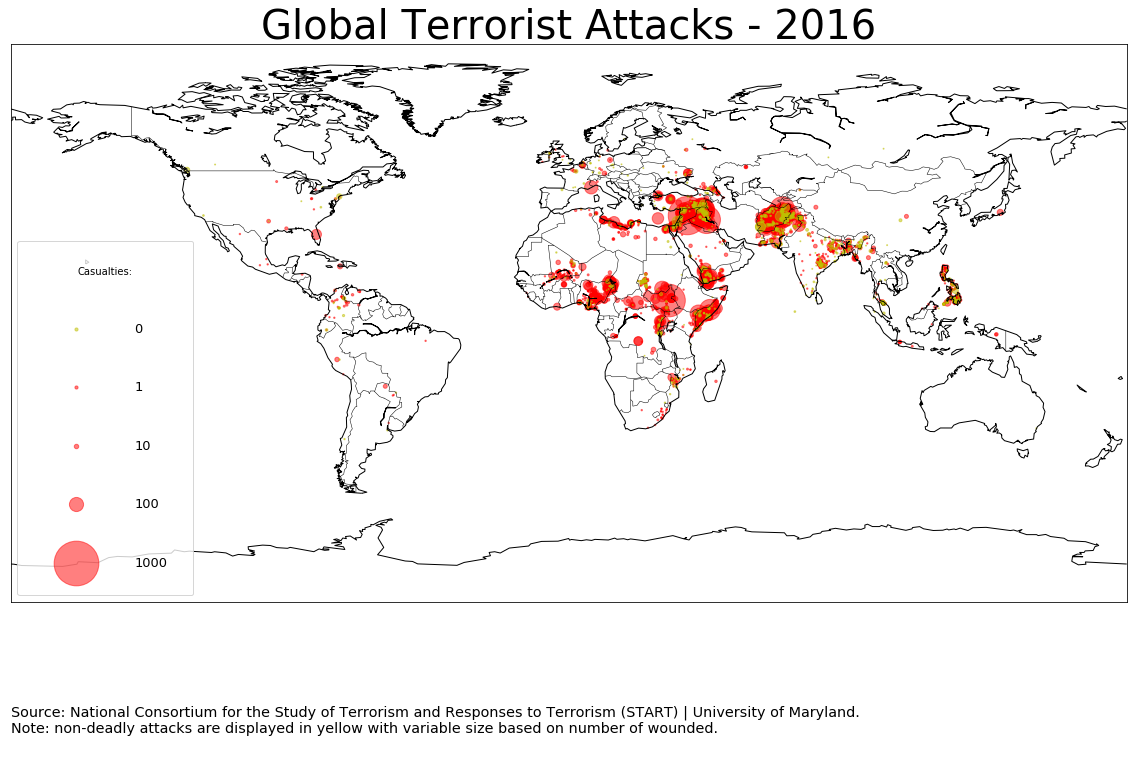

In [23]:
# define caption
caption = '''Source: National Consortium for the Study of Terrorism \
and Responses to Terrorism (START) | University of Maryland. 
Note: non-deadly attacks are displayed in yellow with variable size \
based on number of wounded. 
'''

# create non-cumulative map for each year 
for year in range(1970, 2017):
    lon1 = lons93["lon{}".format(year)] # gehts lons, lats and size for each year
    lat1 = lats93["lat{}".format(year)]
    siz1 = size93["siz{}".format(year)]

    lon0 = lons0k["lon0k{}".format(year)]
    lat0 = lats0k["lat0k{}".format(year)]
    siz0 = size0k["siz0k{}".format(year)] # will plot wounded when attack not deadly
    
    m = Basemap()
    fig = plt.figure(figsize=(20,12))
    m.drawcoastlines()
    m.drawcountries()
    
    
    # define "scatter points" for each legend entry
    leg0 = plt.scatter([],[], s=10, c = "y", alpha=0.5)
    leg1 = plt.scatter([],[], s=10, c = "r", alpha=0.5)
    leg2 = plt.scatter([],[], s=20, c = "r", alpha=0.5)
    leg3 = plt.scatter([],[], s=200, c = "r", alpha=0.5)
    leg4 = plt.scatter([],[], s=2000, c = "r", alpha=0.5)
    # define legend labels
    labels = ["0", "1", "10", "100", "1000"]
    
    
    # set legend
    leg = plt.legend([leg0, leg1, leg2, leg3, leg4], labels, ncol=1, frameon=True, fontsize=13,
                     handlelength=5, loc = 3, borderpad = 2, handletextpad=2, scatterpoints = 1,
                     labelspacing=3.5, title="Casualties:")  

    # compute map proj coordinates.
    x1,y1 = m(lon1,lat1) 
    x0,y0 = m(lon0, lat0)

    m.scatter(x1,y1, s = siz1 * 2, c = 'r', alpha = 0.5)
    m.scatter(x0,y0, s = siz0, c = 'y', alpha = 0.5)

    plt.title("Global Terrorist Attacks - {}".format(year), fontsize=40)
    plt.figtext(0.125, 0.01, caption, size = "x-large")
    plt.savefig("output/yearly/map_{}.png".format(year))
    if year == 2016: # keeps the plot "opened", breaks the loop and display it here.
        break
    plt.close()

plt.show()

## Folium Implementation 

In this section we will create a subsection of the full data frame and plot the data points on an interactive map using the Folium library. [Folium](http://example.com/ "Folium on Github") is a python library that makes it easy to use the [leaflet.js](http://leafletjs.com/) JavaScript library for creating interactive maps on any modern web browser. 

Folium makes it possible to use the strength of leaflet.js directly from python, where the user can create very nice looking and interactive maps with very few lines of code. And you don't even need to know anything about JS. 

The following function will create a popup for each marker that will be implemented later over the folium map. The function goes through the rows of the *data_frame* and gets some of the attributes to be displayed when clicked on the marker.

In [24]:
def make_popups( data_frame ):
    '''generate a list of strings to be displayed as popups when clicked on map marker'''
    popups = []
    for loc in data_frame.iterrows():
        date = "{}.{}.{}".format(str(loc[0])[0:4],str(loc[0])[4:6], str(loc[0])[6:-4])
        city = loc[1].city
        attack_type = loc[1].attacktype1_txt
        attack_group = loc[1].gname
        target = loc[1].targtype1_txt
        total_kill = loc[1].ttkill
        popups.append("{}, {}, type: {}, group: {}, target: {} , dead: {} ".format(date, city,
                                attack_type, attack_group, target, int(total_kill)))
    return popups

The following lines create a new DataFrame for the european data (including Western and Eastern Europe).  In order to keep the number of results manageable, we include only the attacks with one or more casualties. 

In [25]:
# new DataFrame for European values
df_eu = df[(df["nkill"] > 0) & (df["region_txt"].str.contains("Europe"))]

# list of smaller variables to keep
keep4 = ["iyear", "country_txt", "city", "region_txt",
        "latitude", "longitude", "attacktype1_txt", 
        "weaptype1_txt", "targtype1_txt", "gname", 
        "nkill", "nkillter", "ttkill", "nwound"]
df_eu = df_eu[keep4]

# since we are not able to plot, we drop the missing Lat/Lon values
df_eu.dropna(subset=["latitude", "longitude"], how="all", inplace=True)
print("observations in df_eu: ", len(df_eu))

observations in df_eu:  5384


The following lines applies the data frame gathered above and plots in a interactive map.
With credits for: 

- https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/
- https://github.com/python-visualization/folium/blob/master/examples/1000_MarkerCluster.ipynb

In [26]:
locations = list(zip(df_eu["latitude"], df_eu["longitude"]))
popups = make_popups(df_eu)

# define start location, zoom and map tiles
m = folium.Map(location=[52, 13], zoom_start=4, tiles='Cartodb Positron')

# add markers 
m.add_child(MarkerCluster(locations=locations, popups=popups))
# save HTML in a local file
m.save("./output/folium/map_europe.html")

# display interactive map
m

### Note: 
if map is not visible inside the notebook viewer, [the output can be found here](http://userpage.fu-berlin.de/avila/py/map_europe.html). 

# gif working prototype

With the following lines, we create a little animation using built-in functions from matplotlib.
We didnt't find out how to set different colours for different points in a scatter plot based on multiple criterias (deadly and not deadly attacks, as in the graphs above).  It seems one can only apply the `.set_offsets()`, `.set_sizes()` and `.set_color()` once, as they seem to override previous statements.  Applying a colour map also did not work, as all the points were drawn with the same colour (the left-most on the pattern).  Nonetheless, we got the animation working. With the help of the following resources:

- [Louis Tiao's Embedding Matplotlib Animations in Jupyter Notebooks, 2016-04-16 ](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/)

- [Jake VanderPlas' Embedding Matplotlib Animations in IPython Notebooks, 12 May 2013](http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/)


In [29]:
# avoid displaying second plot as png:
%matplotlib qt5 

# start figure, basemap and its elements (for the first frame):

fig = plt.figure(figsize=(10,5))
scat = plt.scatter(x=[],y=[],c = 'r', alpha = 0.5)
m = Basemap()
m.drawcoastlines()
m.drawcountries()

# define "scatter points" for each legend entry
leg0 = plt.scatter([],[], s=5, c = "r", alpha=0.5)
leg1 = plt.scatter([],[], s=6, c = "r", alpha=0.5)
leg2 = plt.scatter([],[], s=15, c = "r", alpha=0.5)
leg3 = plt.scatter([],[], s=105, c = "r", alpha=0.5)
leg4 = plt.scatter([],[], s=1005, c = "r", alpha=0.5)
# define legend labels
labels = ["0", "1", "10", "100", "1000"]

# set legend
leg = plt.legend([leg0, leg1, leg2, leg3, leg4], labels, ncol=1, frameon=True, fontsize=11,
                 handlelength=3, loc = 3, borderpad = 1,
                 handletextpad=1, scatterpoints = 1,
                 labelspacing=1.3, title="Casualties:"
                )


def update(i):
    '''updates each frame of animation'''
    year = 1970 + i
    lon1 = lons93["lon{}".format(year)] 
    lat1 = lats93["lat{}".format(year)]
    siz1 = size93["siz{}".format(year)]
    x1,y1 = m(lon1,lat1) 
    scat.set_offsets(np.dstack((x1, y1)))
    scat.set_sizes(5 + siz1)
    scat.set_color
    plt.title("Global Terrorist Attacks - {}".format(year), fontsize=20)


# create animation    
anim = animation.FuncAnimation(fig, update, frames=47, interval=1000,
                               repeat = False, blit=False)

# change settings to display animation as HTML 
rc('animation', html='html5')   

# display animation
anim

# Results and Discussion

The above analysis can show some of the functionality of different python libraries when dealing with all common steps in a data analysis task. It is interesting to note that very complex outputs, such as the interactive map with **folium**, is actually quite simple to create with its easy-to-use API. On the other hand, a simple animal, or even a simple plot is quite complex to create, requiring quite a few lines of code when using lower level libraries such as **matplotlib**. Also **Pandas** proves to be a central library for most of the tasks we completed, with its very powerfull and rather intuitive API. Another focus was to use the **Jupyer Notebook** itself.  It shows to be a very capable and powerful tool for *interactive* data analysis through the usage of its fields or input and output

With that in mind, python as language proves to be a very powerful and complete language for data analysis, able to yield good results without the need to use other statistical software or languages. 

It is important to make clear, that the central object of this project was the python language itself, and not a statistical analysis about the evolution of terrorism.  For such a analysis, a more complex estimation method such as the [Kernel Density Estimation](https://www.cadcorp.com/products/specialised-applications/hot-spot-mapping-using-kde/) would be better indicated. 
